In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using LinearAlgebra, Plots
import ForwardDiff as FD
import MeshCat as mc 
using JLD2
using Test
using Random
include(joinpath(@__DIR__,"utils/cartpole_animation.jl"))

  Activating environment at `~/devel/hw_ideas/hw2/Project.toml`


animate_cartpole (generic function with 1 method)

# Q2: LQR for nonlinear systems

## Linearization warmup 
Before we apply LQR to nonlinear systems, we are going to treat our linear system as if it's nonlinear. Specifically, we are going to "approximate" our linear system with a first-order Taylor series, and define a new set of $(\Delta x, \Delta u)$ coordinates. Since our dynamics are linear, this approximation is exact, allowing us to check that we set up the problem correctly. 

First, assume our discrete time dynamics are the following:

$$ x_{k+1} = f(x_k,u_k) $$

And we are going to linearize about a reference trajectory $\bar{x}_{1:N}, \bar{u}_{1:N-1}$. From here, we can define our delta's accordingly:

$$ \begin{align} x_k &= \bar{x}_k + \Delta x_k \\ u_k &= \bar{u}_k + \Delta u_k \end{align}$$  

Next, we are going to approximate our discrete time dynamics function with the following first order Taylor series:

$$ 
x_{k+1} \approx f(\bar{x}_k, \bar{u}_k) + \bigg[\frac{\partial f}{\partial x} \bigg|_{\bar{x}_k, \bar{u}_k}  \bigg](x_k - \bar{x}_k) + \bigg[\frac{\partial f}{\partial u} \bigg|_{\bar{x}_k, \bar{u}_k}  \bigg](u_k - \bar{u}_k)
$$

Which we can substitute in our delta notation to get the following:

$$ 
\bar{x}_{k+1} + \Delta x_{k+1} \approx f(\bar{x}_k, \bar{u}_k) + \bigg[\frac{\partial f}{\partial x} \bigg|_{\bar{x}_k, \bar{u}_k}  \bigg]\Delta x_k + \bigg[\frac{\partial f}{\partial u} \bigg|_{\bar{x}_k, \bar{u}_k}  \bigg] \Delta u_k
$$

If the trajectory $\bar{x},\bar{u}$ is dynamically feasible (meaning $\bar{x}_{k+1} = f(\bar{x}_k, \bar{u}_k)$), then we can cancel these equivalent terms on each side of the above equation, resulting in the following:

$$ 
 \Delta x_{k+1} \approx  \bigg[\frac{\partial f}{\partial x} \bigg|_{\bar{x}_k, \bar{u}_k}  \bigg]\Delta x_k + \bigg[\frac{\partial f}{\partial u} \bigg|_{\bar{x}_k, \bar{u}_k}  \bigg] \Delta u_k
$$

In [2]:
function dynamics(params::NamedTuple, x::Vector, u)


    # cartpole physical parameters 
    mc, mp, l = params.mc, params.mp, params.l
    g = 9.81
    
    q = x[1:2]
    qd = x[3:4]

    s = sin(q[2])
    c = cos(q[2])

    H = [mc+mp mp*l*c; mp*l*c mp*l^2]
    C = [0 -mp*qd[2]*l*s; 0 0]
    G = [0, mp*g*l*s]
    B = [1, 0]

    qdd = -H\(C*qd + G - B*u[1])
    return [qd;qdd]

end

function rk4(params::NamedTuple, x::Vector,u,dt::Float64)
    k1 = dt*dynamics(params, x, u)
    k2 = dt*dynamics(params, x + k1/2, u)
    k3 = dt*dynamics(params, x + k2/2, u)
    k4 = dt*dynamics(params, x + k3, u)
    x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end

rk4 (generic function with 1 method)

dlqr converged after 74 iterations
norm(X[end] - xgoal) = 0.0046058791353429844


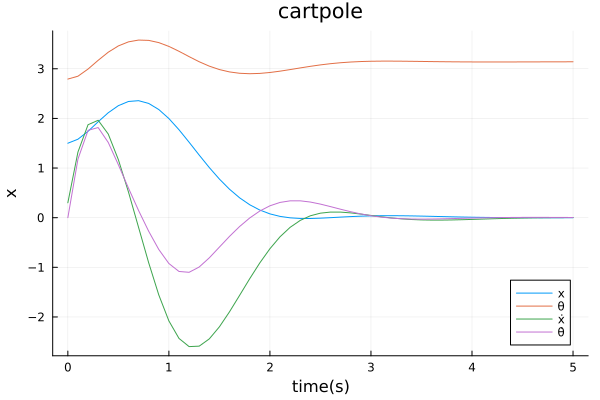

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8806


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("pole" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "b" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x6d, 0x65, 0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x62], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "cart" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x63, 0x61, 0x72, 0x74], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "a" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x6d, 0x65, 0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x61], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{Any}(), ip"127.0.0.1", 8806))

In [25]:
function ihlqr(A::Matrix,       # vector of A matrices 
               B::Matrix,       # vector of B matrices
               Q::Matrix,       # cost matrix Q 
               R::Matrix;       # cost matrix R 
               max_iter = 1000, # max iterations for Ricatti 
               tol = 1e-5       # convergence tolerance
               )::Tuple{Matrix, Matrix} # return two matrices 
        
    # get size of x and u from B 
    nx, nu = size(B)
        
    # initialize S with Q
    S = deepcopy(Q)
    
    # Ricatti 
    for ricatti_iter = 1:max_iter 
        K = (R + B'*S*B)\(B'*S*A)
        Snew = Q + K'*R*K + (A - B*K)'S*(A - B*K)
        if norm(S-Snew,Inf)<tol 
            println("dlqr converged after $ricatti_iter iterations")
            return Snew, K 
        end
        
        # update S 
        S = 1*Snew 
    end
    error("dlqr did not converge")
end
let 
    
    nx = 4 
    nu = 1 
    x0 = [0, pi, 0, 0] + [1.5, deg2rad(-20), .3, 0]
    xgoal = [0, pi, 0, 0]
    ugoal = [0]
    dt = 0.1 
    tf = 5.0 
    t_vec = 0:dt:tf
    N = length(t_vec)
    X = [zeros(nx) for i = 1:N]
    X[1] = x0 
    
    
    params_est = (mc = 1.0, mp = 0.2, l = 0.5)
    params_real = (mc = 1.2, mp = 0.16, l = 0.55)
    
    A = FD.jacobian(_x->rk4(params_est, _x, ugoal, dt), xgoal)
    B = FD.jacobian(_u->rk4(params_est, xgoal, _u, dt), ugoal)
    Q = diagm([1,1,.05,.1])
    Qf = 1*Q
    R = 0.1*diagm(ones(nu))
    Sinf, Kinf = ihlqr(A,B,Q,R)
    
    for i = 1:(N-1)
        u = -Kinf*(X[i] - xgoal)
        X[i+1] = rk4(params_real, X[i], u, dt)
    end
    
    
    @test X[1] == x0 
    @show norm(X[end] - xgoal)
    Xm = hcat(X...)
    display(plot(t_vec,Xm',title = "cartpole",
                 xlabel = "time(s)", ylabel = "x",
                 label = ["x" "θ" "ẋ" "θ̇"]))
    
    # animation stuff
    display(animate_cartpole(X, dt))
    
end

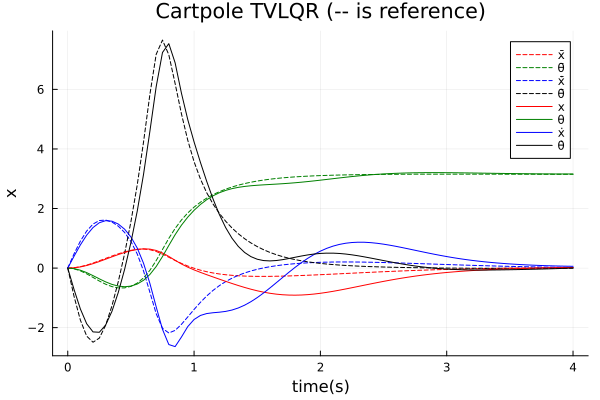

Test Summary: | Pass  Total
track swingup |    3      3


Test.DefaultTestSet("track swingup", Any[], 3, false, false)

In [23]:
function tvlqr(As::Vector{Matrix{Float64}},       # vector of A matrices 
               Bs::Vector{Matrix{Float64}},       # vector of B matrices
               Q::Matrix,               # cost matrix Q 
               R::Matrix,               # cost matrix R 
               Qf::Matrix               # cost matrix Qf 
               )::Tuple{Vector{Matrix{Float64}}, Vector{Matrix{Float64}}} # return two vectors of matrices 
    
    # make sure A and B are same length 
    N = length(As) + 1 
    @assert length(Bs) == (N - 1)
    
    # get size of x and u from B 
    nx, nu = size(Bs[1])
    
    # instantiate S and K 
    S = [zeros(nx,nx) for i = 1:N]
    K = [zeros(nu,nx) for i = 1:N-1]
    
    # initialize S[N] with Qf 
    S[N] = deepcopy(Qf)
    
    # Ricatti 
    for k = (N-1):(-1):1 
        A = As[k]
        B = Bs[k]
        K[k] = (R + B'*S[k+1]*B)\(B'*S[k+1]*A)
        S[k] = Q + K[k]'*R*K[k] + (A - B*K[k])'S[k+1]*(A - B*K[k])
    end
    
    return S, K 
end
    
@testset "track swingup" begin 
    DATA = load(joinpath(@__DIR__,"swingup.jld2"))
    Xbar = DATA["X"]
    Ubar = DATA["U"]
    
    nx = 4 
    nu = 1 
    dt = 0.05 
    tf = 4.0 
    t_vec = 0:dt:tf
    N = length(t_vec)
    X = [zeros(nx) for i = 1:N]
    X[1] = [0, 0, 0, 0.0] 
    
    @assert norm(X[1] - Xbar[1]) < 1e-12
    
    Q = diagm([1,1,.05,.1])
    Qf = 10*Q
    R = 0.05*diagm(ones(nu))

    params_est = (mc = 1.0, mp = 0.2, l = 0.5)
    params_real = (mc = 1.2, mp = 0.16, l = 0.55)
    As = [FD.jacobian(_x->rk4(params_est, _x, Ubar[i], dt), Xbar[i]) for i=1:(N-1)]
    Bs = [FD.jacobian(_u->rk4(params_est, Xbar[i], _u, dt), Ubar[i]) for i=1:(N-1)]
    
    S,K = tvlqr(As,Bs,Q,R,Qf)
    
    for i = 1:(N-1)
        Δx = X[i] - Xbar[i]
        Δu = -K[i]*Δx
        u = Ubar[i] + Δu
        X[i+1] = rk4(params_real, X[i], u, dt) 
    end
    
    xn = X[N]
    @test norm(xn)>0
    @test 1e-6<norm(xn - Xbar[end])<.2
    @test abs(abs(rad2deg(xn[2])) - 180) < 5 # within 5 degrees 
    
    Xm = hcat(X...)
    Xbarm = hcat(Xbar...)
    plot(t_vec,Xbarm',ls=:dash, label = ["x̄" "θ̄" "ẋ̄" "θ̇̄"],lc = [:red :green :blue :black])
    display(plot!(t_vec,Xm',title = "Cartpole TVLQR (-- is reference)",
                 xlabel = "time(s)", ylabel = "x",
                 label = ["x" "θ" "ẋ" "θ̇"],lc = [:red :green :blue :black]))
    
    # animation stuff
    display(animate_cartpole(X, dt))

    
end